## Jupyter Notebook for data analysis of the muon experiment

This notebook contains the code for determining the muon lifetime from data recorded with the
experimental setup in the advanced laboratory course (F-praktikum).The data consists of real-time selected signatures with double pulses, where the first pulse originates from a muon detected in the large muon detectors. The second pulse is either a random coincidence within the time window of 14 µs or comes from the decay particle of a muon stopped in or near the detectors.

The assumed data format is CSV, as recorded with the configuration file `lifetime_setup.yaml`. An exponential distribution of muon lifetimes with a constant background of random coincidences is assumed as the model function. The free parameters of the model are the (mean) muon lifetime $\tau_\mu$
and the fraction $f$ of random coincidences in the (configurable) time window between 0.5 and 14.5 µs after the trigger pulse. Due to the low number of events recorded in approximately 30 minutes, a method based on the negative-log-likelihood function is used ("unbinned log-likelihood fit").

For data filtering, the `pandas` data analysis tool is used. For model fitting, the functions of the `PhyPraKit` and `kafe2` packages are recommended. If necessary, additional background information can be found in the Jupyter tutorials `pandasBasics.ipynb`, `negLogLFits.ipynb`, and `advancedFitting.ipynb` at the URL https://etp.kit.edu/~quast/jupyter.


### Measurement of the lifetime of stopped muons

This notebook is complete and is intended to be applied to test data after the initial setup adjustments have been made. Its purpose is to serve as verification of the correct configuration by conducting a measurement lasting approximately 30 minutes to determine the muon lifetime with an accuracy of approximately $\pm$0.5 µs.

The methods presented here can be directly applied to the data obtained in the long-term measurement with the magnetic field turned on.

### 1. Import of all necessary packages

In [13]:
import time
import numpy as np     
import pandas as pd                 # Powerful package for the handling of large datasets
import matplotlib.pyplot as plt     # Graphics library
# Package for model fits ("Wrapper-Function in PhyPraKit)
from PhyPraKit import mFit, hFit, k2hFit

### 2. Read in of data

In [14]:
LT1 = "/home/shivamkumar/Documents/KIT COURSES/Lab/Exp1/sam/muon_properties/analysis/lifetime_one_week.txt"#"/home/shivamkumar/Documents/KIT COURSES/Lab/Exp1/sam/muon_properties/analysis/lifetime.txt"   # data in csv-Format produced with config `lifetime_setup.yaml`

# convenient abbreviations for column names
# - for measurements with 3 panels
dp_columns_3p = { 0:'EvId',  1:'EvT', 2:'tDead', 3:'dT', 
               4: 'h1A',  5:'p1A', 6: 'I1A',
               7: 'h1B',  8:'p1B', 9: 'I1B', 
               10: 'h1C', 11:'p1C', 12:'I1C', 
               13:'h2A', 14:'p2A', 15:'I2A', 
               16:'h2B', 17:'p2B', 18:'I2B', 
               19:'h2C', 20:'p2C', 21:'I2C',
                }
# - for measurements with 4 panels
dp_columns_4p = { 0:'EvId',  1:'EvT', 2:'tDead', 3:'dT', 
               4: 'h1A',  5:'p1A', 6: 'I1A',
               7: 'h1B',  8:'p1B', 9: 'I1B', 
               10: 'h1C', 11:'p1C', 12:'I1C', 
               13: 'h1D', 14:'p1D', 15:'I1D', 
               16:'h2A', 17:'p2A', 18:'I2A', 
               19:'h2B', 20:'p2B', 21:'I2B', 
               22:'h2C', 23:'p2C', 24:'I2C',
               25:'h2D', 26:'p2D', 27:'I2D'
                }

# read the data and store in a pandas dataframe
lifetime_df = pd.read_csv( LT1,
     skiprows=1, comment='#', delimiter='\t', header=None).rename(columns = dp_columns_4p)
# adjust time unit - was µs in old data, now s
time_unit= 1.e-6 # adjust if time is in µs
 

### 3. Quality control of the recorded data
First off, it is recommended to survey the quality of the data:

   - Statistical information regarding the data taking
   - Temporal progression of the recorded data
   - Pulse-height-distribution


In [15]:
import time
from scipy.stats import trim_mean

def dataquality_check(df):
    """check data quality of data in dataframe df
    """
    # print information  on data (from header)
    header = df[['EvT','EvId', 'tDead']]
    print('** Infomation on data:')

    # event times in seconds 
    EvT_s = header['EvT']*time_unit  # event times in s 

    # plot trigger and event rate
    print('  Date of 1st Event: ', time.ctime(EvT_s.values[0]))
    print('  Date of last Event:', 25*' ', time.ctime(EvT_s.values[-1]))

    NEvents = header['EvId'].values[-1]
    Nsel = len(header['EvId'])
    Duration = (EvT_s.values[-1] - EvT_s.values[0])
    print('     triggered Events: {}  selected Pulses: {}  Duration: {}s  Rate: {:.1f}Hz'.format(
        NEvents, Nsel, Duration, NEvents/Duration))
    Tbetween = np.diff(EvT_s.to_numpy()) # in seconds
    print('     mean time between selected pulses: {:.2g}s'.format(Tbetween.mean()))

    T0 = EvT_s[0]
    #  -  number of events triggered between selected events in data set
    dN = np.diff(header['EvId'].to_numpy())
    Nbins= 100
    Wbin = Duration/Nbins
    _ = plt.hist(EvT_s[1:] - T0, weights = dN, bins=Nbins, rwidth=0.6, label='trigger rate', alpha=0.5)
    _ = plt.hist(EvT_s[1:] - T0, bins=Nbins, rwidth=0.6, label='rate', alpha=0.5, )
    plt.text(0.1, 0.9, "Bin Width={:.3g}s".format(Wbin), color = 'darkred', transform=plt.gca().transAxes)
    plt.yscale('log')
    plt.suptitle('Event Rate')
    plt.xlabel('time since start (s)')
    plt.ylabel('# entries / bin')
    plt.legend(loc='upper right')
    plt.show()

    # plot time between events                                
    _ = plt.hist(Tbetween[Tbetween < Tbetween.mean()*100], bins=50, log=True)
    plt.xlabel('Time between events (s)')
    plt.ylabel('# entries / bin')
    plt.show()

    # show pulse height distributions
    df['h1A'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 1st pulse Panel A (mV)')
    plt.show()
    df['h1B'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 1st pulse Panel B (mV)')
    plt.show()
    df[df['h2B']>0.]['h2B'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 2nd pulse Panel B (mV)')
    plt.show()
    df[df['h2C']>0.]['h2C'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 2nd pulse Panel C (mV)')
    plt.show()


 *** Data quality checks ***

** Infomation on data:
  Date of 1st Event:  Thu Jan  1 01:29:05 1970
  Date of last Event:                           Thu Jan  1 01:29:06 1970
     triggered Events: 68373842  selected Pulses: 156889  Duration: 0.5926719901617616s  Rate: 115365401.3Hz
     mean time between selected pulses: 3.8e-06s


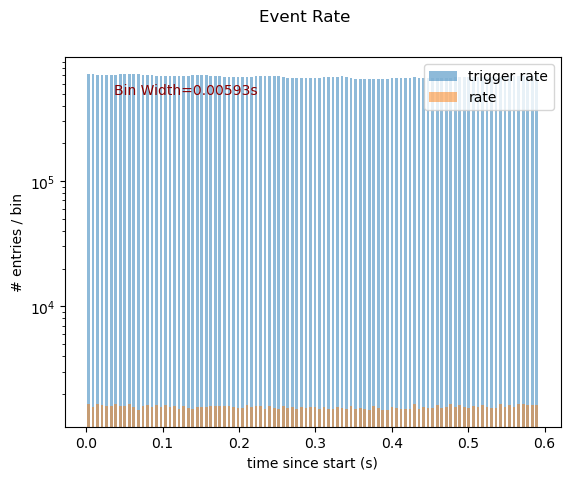

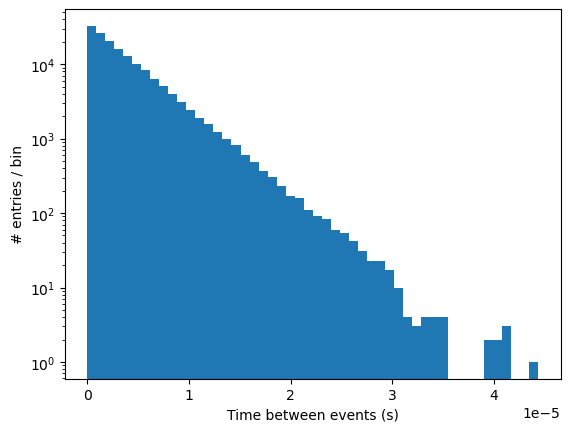

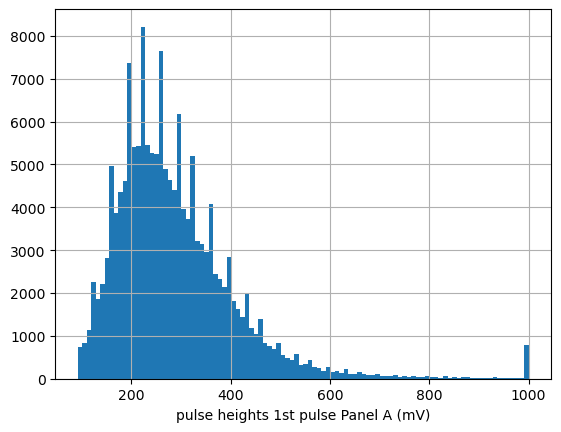

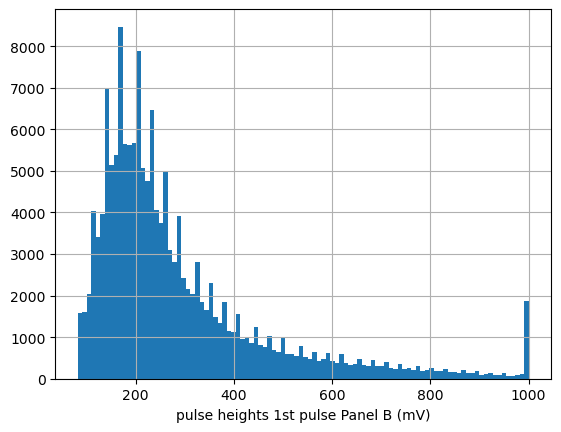

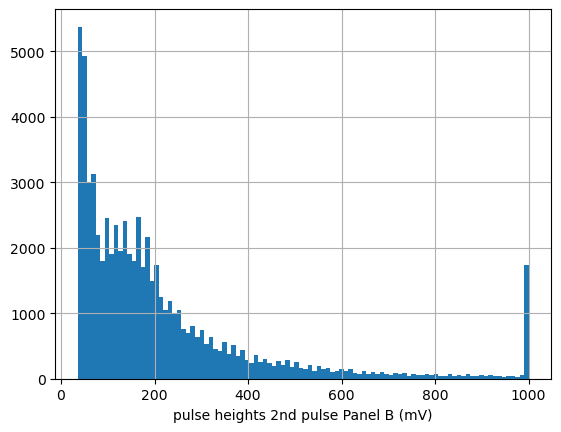

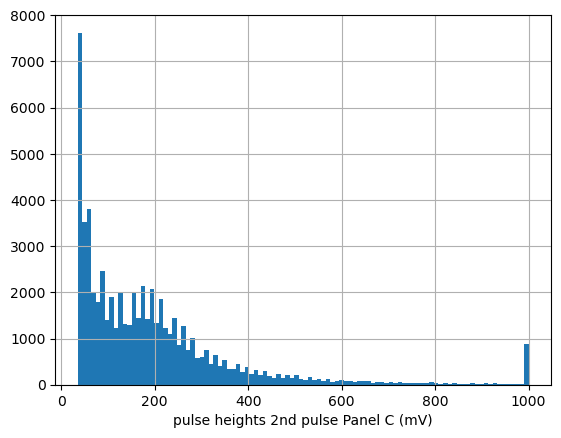

In [16]:
print("\n *** Data quality checks ***\n")
dataquality_check(lifetime_df)

### 4. Distribution of time between double pulses

If the distributions above meet expectations, the next step involves filtering the data to optimize the proportion of valid double pulses. 
To achieve this, the criteria considered during data acquisition are tightened.

You will observe that *pandas* provides very efficient and powerful methods for data selection, especially by applying boolean masks to the indexed rows in the data. These boolean masks are defined by selection criteria and can be applied to the entire dataset in a single step.

Initially, an appropriate time window and threshold values for the observed pulse heights have to be defined. For selection, it is further required that there is a coincidence of the first pulse in at least two of the panels. This ensures that the start is definitely a genuine muon and not a random coincidence. Additionally, there has to be a second pulse in at least one of the panels. The distribution of pulse heights will be displayed as a histogram for verification.

**Note:** The time unit of the recorded data is `ns` (nanoseconds); the factor of `1e9` ensures the conversion to the preferred time unit, seconds, in the following steps.

In [17]:
# acceptance definition 

# -----------------------------------------------
# valid life time interval
a0 = 1.0e-6
b0 = 14.5e-6

# pulse height thresholds for trigger pulse in Panels A & B
th_1A_low = 75
th_1A_high = 1100 # not effective above 1. !
th_1B_low = 75
th_1B_high = 1100
th_1C_low = 50.
th_1C_high = 1100.
th_1D_low = 50.
th_1D_high = 1100.

# pulse height thresholds for 2nd pulse in Panels B ("Top") & C ("Bottom")
th_2A = 75.
th_2B = 75.
th_2C = 75.
th_2D = 75.

# -----------------------------------------------

def select(df, signature = None):
    """Define acceptance for "good evnts"
       - myon stopped in copper plate
       - decay to top or bottom detectors
    """

    # criteria for 2-fold coincidences
    mask_AB = (df['h1A'] > th_1A_low)  & (df['h1A'] < th_1A_high) & \
                (df['h1B'] > th_1B_low)  & (df['h1B'] < th_1B_high) 
    mask_AC = (df['h1A'] > th_1A_low)  & (df['h1A'] < th_1A_high) & \
                (df['h1C'] > th_1C_low)  & (df['h1C'] < th_1C_high)
    mask_BC = (df['h1B'] > th_1B_low)  & (df['h1B'] < th_1B_high) & \
                (df['h1C'] > th_1C_low)  & (df['h1C'] < th_1C_high) 
    mask_AD = (df['h1A'] > th_1A_low)  & (df['h1A'] < th_1A_high) & \
                (df['h1D'] > th_1D_low)  & (df['h1D'] < th_1D_high)
    mask_BD = (df['h1B'] > th_1B_low)  & (df['h1B'] < th_1B_high) & \
                (df['h1D'] > th_1D_low)  & (df['h1D'] < th_1D_high) 
    mask_CD = (df['h1C'] > th_1C_low)  & (df['h1C'] < th_1C_high) & \
                (df['h1D'] > th_1D_low)  & (df['h1D'] < th_1D_high) 
    
    # criteria for stopped muon in copper plate
    mask_stopped = (df['h1A'] > th_1A_low)  & \
                   (df['h1A'] < th_1A_high) & \
                   (df['h1B'] > th_1B_low)  & \
                   (df['h1B'] < th_1B_high) & \
                   (df['h1C'] < th_1C_low)  & \
                   (df['h1D'] < th_1D_low) 
 
    # bookean mask for 2nd pulses: one valid pulse in either A, B, C or D    
    mask2_up =  (df['h2A'] > th_2A) | (df['h2B'] > th_2B) 
    mask2_down =  (df['h2C'] > th_2C) | (df['h2D'] > th_2D)  

    if signature == "all":        

      # select set of conditions
        filter_mask = (mask_AB | mask_AC | mask_BC |  \
                       mask_AD | mask_BD | mask_BD ) & \
                      (mask2_up | mask2_down)

      # apply filter conditions
        sel = lifetime_df[ filter_mask]
        print('shape of selected data:    ', sel.shape)
        return sel
    
    elif signature == "top":
      # select events with stopped muon in copper and decay to top detectors
        Tsel = df[ mask_stopped & mask2_up]
        print('shape top detector:    ', Tsel.shape)
        return Tsel
        
    elif signature == "bottom":
      # selecct events with stopped muon in copper decay to bottom detectors
        Bsel = df[ mask_stopped & mask2_down]
        print('shape bottom detector: ', Bsel.shape)
        return Bsel
    else:
        print('!!! unknown signature')
        return None

shape top detector:     (45801, 28)
 ** number of selected events:  37539


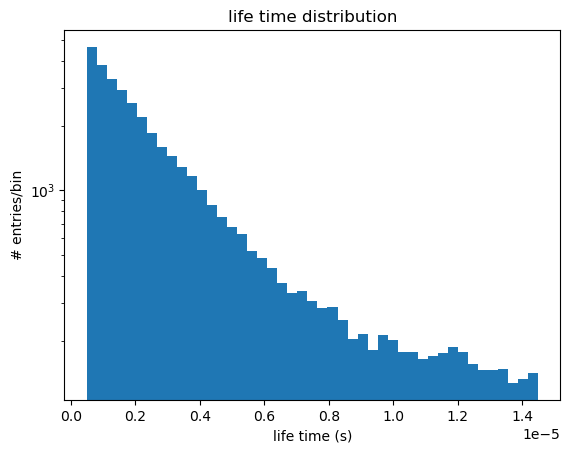

In [19]:
# Filter events
Tsel = select(lifetime_df, "top")

# Plot lifetime distribution
# --------------------------

# - acceptance definition: valid life time interval
a0 = 0.5e-6
b0 = 14.5e-6

# - select data in range [a0, b0]
dT = Tsel[ (Tsel['dT'] > a0*1e9) & (Tsel['dT'] < b0*1e9)].dT.values*1.0e-9
print(" ** number of selected events: ", len(dT))

# show result in a histogram
nbins = 45
bin_entries, bin_edges, _ = plt.hist(dT, bins=nbins)
plt.title('life time distribution')
plt.xlabel('life time (s)')
plt.ylabel('# entries/bin')
#plt.ylim(0,1000)
plt.yscale('log')
plt.show()

### 5. Fitting of exponential lifetime and background distribution

As the final step, we perform the model fitting. The model function should be considered as a probability density (i.e., normalized to one), which looks like the following:

In [22]:
def exp_decay(t, tau=2.19e-6, f=0.1, a=a0, b=b0):
    """
    Probability density of an exponential decay on top of a flat background in interval [a0, b0]
    """
    return (1 - f) * np.exp(-t / tau) / (tau * (np.exp(-a / tau) - np.exp(-b / tau))) + \
             f / (b - a)

Since there are only a few hundred events left, and the distribution drops sharply, the above histogram is not well-suited as the basis for data analysis. Therefore, a **likelihood fit** should be performed directly on the unbinned data. This can be conveniently done using the `PhyPraKit.pyhFit.mFit` function.

`phyFit` is a very staight-forward interface to the mimimization and error analyis package `iminuit`.
`mFit` implements a fit based on the negative log-likelihood of a user-defined probability-density 
function for unbinned data. 

**Note** that the fit range is reflected by the parameters *a* and *b* in the density function;  these are not
free parameters of the fit and are therefore declared as *fixed* in the options passed to the fitting procedure. 

**Note:** The more universal fitting package *kafe2* contains a similar example in the subdirectory 
`examples/010_unbinned_fit/01_unbinned.py` which can be adapted to be used here.  

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_311727/2429290761.py:12: SyntaxWarning: invalid escape sequence '\D'
  axis_labels=['life time  ' + '$\Delta$t (s)',
/tmp/ipykernel_311727/2429290761.py:13: SyntaxWarning: invalid escape sequence '\D'
  'Probability Density  pdf($\Delta$t; *p)'],
/tmp/ipykernel_311727/2429290761.py:14: SyntaxWarning: invalid escape sequence '\m'
  data_legend = '$\mu$ lifetime data',


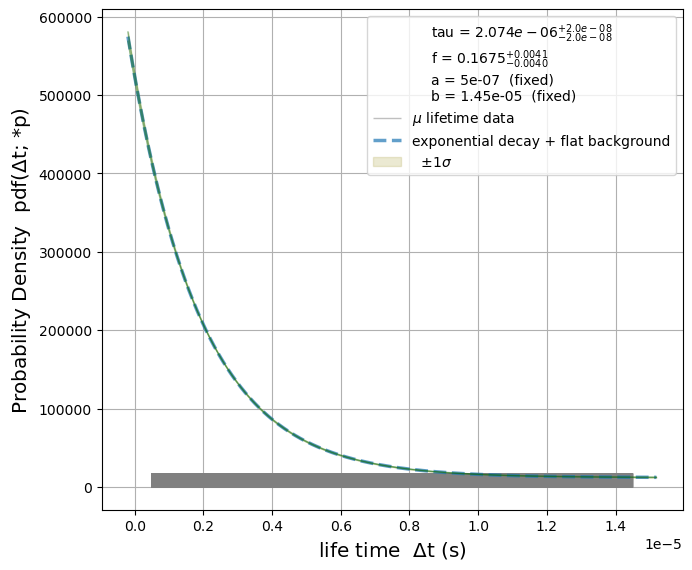


*==* unbinned ML Fit Result:
 parameter names:        ['tau' 'f' 'a' 'b']
 parameter values:       [2.07403108e-06 1.67477705e-01 5.00000000e-07 1.45000000e-05]
 neg. parameter errors:  [-1.97577935e-08 -4.04263940e-03]
 pos. parameter errors:  [1.99889063e-08 4.05754462e-03]
 correlations : 
 [[ 1.         -0.62630084]
 [-0.62630084  1.        ]]


<Figure size 640x480 with 0 Axes>

In [23]:
from PhyPraKit.phyFit import mFit  

# Fit time between pulses
results = mFit( exp_decay,        # the paramter-dependent pdf
       data = dT,                 # data  
       limits=('f', 0., 1.),      # parameter limits
       fixPars = ['a', 'b'],      # fixed parameter(s) 
       neg2logL = True,           # use -2*ln(L)
       plot=True,                 # plot data and model
       plot_band=True,            # plot model confidence-band
       plot_cor=False,            # do not plot profiles likelihood and contours
       axis_labels=['life time  ' + '$\Delta$t (s)', 
                       'Probability Density  pdf($\Delta$t; *p)'], 
       data_legend = '$\mu$ lifetime data',    
       model_legend = 'exponential decay + flat background' )
# Print results 

plt.savefig('Muon_lifetime_fit.png')

pvals, perrs, cor, gof, pnams = results.values()
print('\n*==* unbinned ML Fit Result:')
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:,0])
print(" pos. parameter errors: ", perrs[:,1])
print(" correlations : \n", cor)  


## *Task:* Comment and evaluate the result!

## Addendum

This concludes this part of the task. If you are satisfied with the obtained muon lifetime, you should now start the long-term measurement with the magnetic field turned on.

While waiting for the initial data, you may revisit this notebook and examine the difference between an unbinned and a binned log-likelihood fit to a histogram. For the large dataset that the long-term measurement will produce, the method used above is numerically very inefficient because the negative logarithm needs to be calculated individually for each event in each iteration step of the fit. In contrast, when fitting directly to the histogram generated above, only the counts in each bin need to be considered. With a sufficiently large numbers of recorded double pulses, the methods are practically identical, and hence the numerically more efficient one can be used.

Now, try the histogram fit, which you can also use for the long-term data. With the provided wrapper functions, this can be done easily with *PhyPraKit.phyFit* or *kafe2*.

## Binned log-likelihood fit with `PhyPraKit` 

For large data sets, a fit to a historgram assuming a Poisson distribution of the numbers of entries
produces results that are equivalent to an unbinned fit with much less computational effort. Note
that binning leads to a loss of information because values are approximated by the bin center
they fall into. 
The interface `hFit` of the package `PhyPraKit.phyFit` provides an easy way to perform such a fit 
to the same user-defined density function thas has been used above in the unbinned case. Note that also 
Bins with  small or no entries are treated correctly by this package (and not simply ignored as in many 
other programs). 

**Hint:** *Use this version for the fits to the large data sets required for the spin measurement.* 

<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_311727/3006939035.py:16: SyntaxWarning: invalid escape sequence '\ '
  axis_labels=['dT (s)', '  # \  f(x, *par)'],


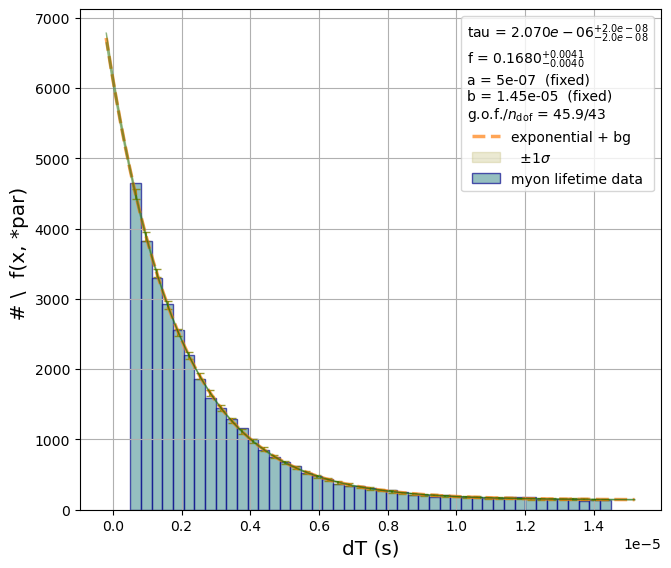


*==* binned ML Fit Result:
 parameter names:        ['tau' 'f' 'a' 'b']
 goodness-of-fit: 45.9
 parameter values:       [2.07040241e-06 1.68044074e-01 5.00000000e-07 1.45000000e-05]
 neg. parameter errors:  [-1.97410256e-08 -4.04731672e-03]
 pos. parameter errors:  [2.00160034e-08 4.05649862e-03]
 correlations : 
 [[ 1.        -0.6297962]
 [-0.6297962  1.       ]]


In [24]:
from PhyPraKit.phyFit import hFit

#  
# ---  perform fit  to Top data with phyFit.hFit 
#       using the histogram produced above 
#

hFit_result = hFit( 
       exp_decay,               # the fit model
       bin_entries, bin_edges,  # bin entries and bin edges
       limits=('f', 0., 1.),    # parameter limits
       fixPars = ['a', 'b'],    # fix parameter(s) 
       plot=True,               # plot data and model
       plot_band=True,          # plot model confidence-band
       plot_cor=False,          # plot profiles likelihood and contours
       axis_labels=['dT (s)', '  # \  f(x, *par)'], 
       data_legend = 'myon lifetime data',    
       model_legend = 'exponential + bg',
       return_fitObject = True
    )
# Print results 
pvals, perrs, cor, gof, pnams = hFit_result.getResult().values()
print('\n*==* binned ML Fit Result:')
print(" parameter names:       ", pnams)
print(" goodness-of-fit: {:.3g}".format(gof))
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:,0])
print(" pos. parameter errors: ", perrs[:,1])
print(" correlations : \n", cor)  


## Task: Comment and evaluate the result!

**Addendum:**   For later use, it will be necessary to generate and display the profile likelihood regarding a parameter. The function `hfit.plot_Profile(parameter, range=(<min>, <max>)` is used for this purpose. An example looks like this:

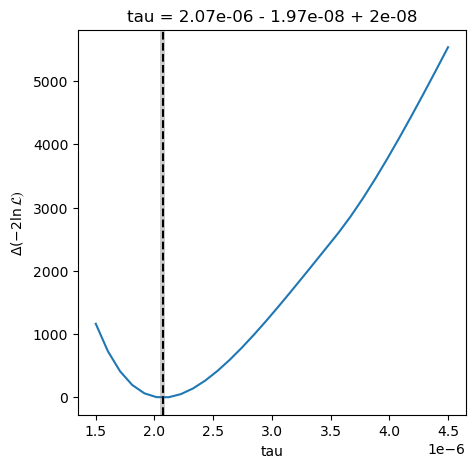

In [25]:
p2nlL = hFit_result.plot_Profile('tau', range=(1.5e-6, 4.5e-6) )

From the profile likelihood, confidence intervals around the best-fit value or exclusion limits for the corresponding parameter can be read. We will also use this method later to assess the significance of an observed spin oscillation.

## Alternative using `kafe2`

The `kafe2`package offers a number of options to control binned likelihood fits. It is therefore more
convenient to use a wrapper-function as provided by `PhyPraKit.k2hFit`. This is shown in the example 
below. 

**Note** that the details of the implemenations of the binned fit differ between *kafe2* and *phyFit*, 
e.g. the precision for the integration of the density distribution over bins to obtain the predicted
number of entries in each bin.  

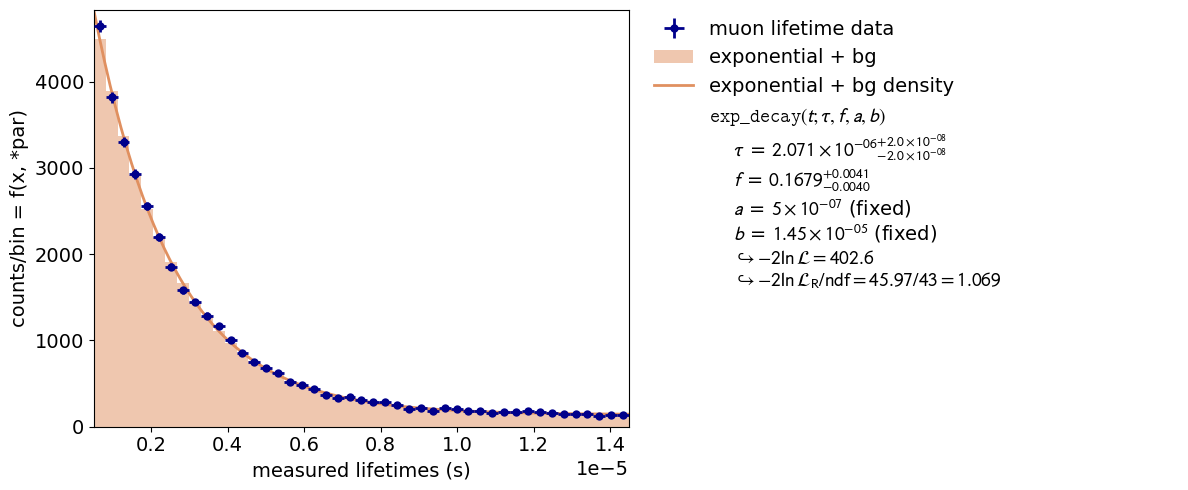

In [26]:
from PhyPraKit import k2hFit

par_values, par_uncert, cor, gof = k2hFit( 
       exp_decay,                         # the fit model
       dT,                                # the raw data 
       bin_edges,                         # bin edges
       p0 =[2.e-6, 0.3, a0, b0],          # initial values
       limits=('f', 0., 1.),              # parameter limits
       fixPars = [['a', a0], ['b', b0]],  # fix parameter(s) 
       use_GaussApprox = False,  # Poisson Likelihood
       plot = True, plot_cor = False,
       showplots = True, plot_band=True, plot_residual=False,
       quiet = True,
       axis_labels = ['measured lifetimes (s)', 'counts/bin = f(x, *par)'],
       data_legend = 'muon lifetime data',    
       model_legend = 'exponential + bg',
       model_expression=None,
       model_name=None, 
       model_band = r'$\pm 1 \sigma$',           
       fit_info=True, asym_parerrs=True    
    )

*Note:*  The value for $-2{\rm ln}{\cal L}$ corresponds to the value of twice the negative logarithm of the likelihood at the optimum. When comparing two fits, for example, with a parameter left free in one case and fixed to a certain value in the other, the difference in the values for $-2{\rm ln}{\cal L}$ corresponds to the square of the so-called $z$-value. This is relevant for hypothesis tests, as needed for the evaluation of the long-term measurement.

**By the way:** The value $-2{\rm ln}{\cal L_R/{\rm ndf}}$ is a measure of the goodness of fit (gof) and corresponds to the value for $\chi^2$ per degree of freedom (ndf="number of degrees of freedom") in fits with Gaussian uncertainties. For large values of entries in the bins, gof/ndf converges to $\chi^2$/ndf.

## Outlook

For the evaluation of the long-term data, you only need to replace the model function for exponential decay in the proposed procedure with the model that includes modulation, described in the instructions, and adjust the selection criteria to enrich the dataset with as many muons stopped in the copper plate as possible. Since a stable fit of all free parameters in the model is not possible with the data from one week, you should set most of the parameters to expected values for a muon spin of 1/2. The only additional free parameter in the model is then the modulation amplitude, which you need to adjust, along with the muon lifetime and the fraction of background events.

For checking the significance, you can use the $z$-value, as described in the instructions. The square root of the difference in the $-2{\rm ln}{\cal L}$ values for the fit of the exponential model with zero modulation and the value of $-2{\rm ln}{\cal L}$ at the fitted optimum. You can obtain these values either from the respective fit results or from the graphical representation of the profile likelihood.

*If you have any questions about the procedure, be sure to clarify them with your supervisor!*